# TERA - Aula 28
## Sistemas de Recomendação

Objetivos gerais da aula:
- Apresentar técnicas clássicas de sistemas de recomendação
- Redução de dimensionalidade
- Análise de tópicos

# Índice

- [Introdução](#Introdução)
- [Recomendação Baseada em Conteúdo](#Recomendação-Baseada-em-Conteúdo)
- [Redução de Dimensionalidade](#Redução-de-Dimensionalidade)
- [Topic Analysis](#Topic-Analysis)
- [Filtro-Colaborativo](#Recomendação-com-Filtro-Colaborativo)

In [1]:
# Imports usados no curso
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-colorblind')

In [3]:
# Pasta contendo os dados:
ROOT_FOLDER = os.path.realpath('..')
DATASET_FOLDER = os.path.join(ROOT_FOLDER,'datasets')

# Introdução

Em poucos anos a internet revolucionou o mercado de consumo mundial e a forma como os clientes interagem com os vendedores. Uma das dinâmicas criadas mais importantes a partir dessa revolução é a de sistemas de recomendação. Todos devem já ter notado o quanto e-commerces como a Amazon, Best Buy e até empresas brasileiras acertam ao recomendar certos tipos de produto para seus clientes, que muitas vezes nem os estavam procurando (veja esse [artigo](https://www.techemergence.com/use-cases-recommendation-systems/)). Isso não acontece mais apenas em e-commerces, mas também com provedores de música (Spotify), de filmes (Netflix) ou vídeos em geral (Youtube). 

Esse fenômeno só ocorre devido a um fator: **dados**. As empresas atualmente possuem muita informação sobre os seus produtos e os seus usuários. É muito fácil obter, hoje em dia, os interesses dos clientes sobre seus produtos. Seja o fato de o vendedor comprar um produto, dar um review ou apenas clicar, já é suficiente para uma empresa mapear os interesses dos usuários e tentar direcionar produtos que seriam relevantes para o usuário sem nem mesmo ele saber!

Os sistemas de recomendação se baseiam, basicamente, em encontrar relações entre compradores e produtos. Mais especificamente, existem dois grandes grupos de sistemas de recomendação:
- **Proximidade de produtos**: Tem o objetivo de encontrar produtos similares aos consumidos por um cliente. Se um cliente possui o interesse em um determinado produto, o sistema de recomendação pode tentar encontrar outros produtos similares para indicar para o cliente.
- **Proximidade entre clientes** (Filtro Colaborativo): Tem o objetivo de encontrar clientes com interesses semelhantes. Suponha que exista um cliente X que consuma os produtos A e B, enquanto um outro cliente Y tem interesse nos produtos A, B e C. Como eles possuem interesses semelhantes (produtos A e B), o sistema de recomendação poderia indicar o produto C para o cliente X.

Existem diversos outros tipos de sistemas de recomendação que fogem do escopo desse material. Mais informações podem ser vistas nesse [link](https://www.techemergence.com/use-cases-recommendation-systems/).

---
# Recomendação Baseada em Conteúdo

### Recomendação Produtos Elo7

Vamos começar com um case simples de recomendação de produtos do Elo7. Esse conjunto de dados contém título e uma pequena descrição de produtos da categoria casamento. Vamos verificar se conseguimos utilizar essas informações para recomendar produtos para usuários. Para isso, vamos utilizar um método de recomendação que é a recomendação baseada em conteúdo.

In [4]:
df_cat = pd.read_csv(os.path.join(DATASET_FOLDER, 'subcategory_elo7_dataset.csv'), sep=';')

Vamos escolher um sample dos produtos para conseguirmos trabalhar com os dados na memória.

In [5]:
df_cat = df_cat.sample(n=10000)

Nosso vetor de atributos vai ser uma mistura de título e pequena descrição. Podemos utilizar outras variações, mas vamos manter as coisas simples.

In [7]:
df_cat['title_desc'] = df_cat['title'] + ' ' + df_cat['short_description']

In [8]:
df_cat.head()

,title,short_description,url,title_desc
10578,noivinhos divertidos topo bolo rio,noivinhos topo bolo biscuit 10 cm altura faco ...,https://www.elo7.com.br/jfndgm/dp/B6A1D4,noivinhos divertidos topo bolo rio noivinhos t...
42,convite casamento,servir razao emocao tocar alma todos convites ...,https://www.elo7.com.br/jfndgm/dp/850FA3,convite casamento servir razao emocao tocar al...
61375,caixa 4 bombons flores 02,caixa 4 bombons otima opcao presentear chocola...,https://www.elo7.com.br/jfndgm/dp/6FCC99,caixa 4 bombons flores 02 caixa 4 bombons otim...
23432,kit amor 2,tal decorar casa quarto cantinho comemoracao d...,https://www.elo7.com.br/jfndgm/dp/A4A737,kit amor 2 tal decorar casa quarto cantinho co...
40033,topo bolo noivinhos,confeccionado biscuit personalize envie fotos ...,https://www.elo7.com.br/jfndgm/dp/5ADC46,topo bolo noivinhos confeccionado biscuit pers...


A matriz de atributos vai ser criada utilizando o método Tf-Idf. Esse método é muito utilizado na prática e funciona bem para a maioria dos casos. Poderíamos testar outras formas de fazer esse embedding, mas vamos começar assim.

In [9]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

In [10]:
X = tfidf.fit_transform(df_cat['title_desc'])

Note as dimensões finais do modelo. Ela contém 10000 linhas que representam o número de documentos utilizados e 5000 colunas que representam as palavras pertencentes ao vocabulário escolhido.

In [11]:
X.shape

(10000, 5000)

In [12]:
doc_target = 14

In [13]:
# Produto escolhido
df_cat.iloc[doc_target]['title']

'copo long drink led festa formatura'

###### Cálculo da recomendação - Padrão
Comparações
- [PCA](#Cálculo-da-recomendação---PCA)
- [NMF](##Cálculo-da-recomendação---NMF)

In [73]:
## Solução
## Calcular a similaridade de cossenos desse artigo em relação a todos os outros e retornar os mais similares.
## Se o usuário gostou desse artigo (consumiu), provavelmente gostará de outros semelhantes.

# Passo 1: Calcula, para cada par, a similaridade de cossenos
from sklearn.metrics.pairwise import cosine_similarity

# Matriz quadrada NxN (N = número de documentos) -> distância entre cada item (diagonal = 1)
similarity_matrix = cosine_similarity(X)
print('Tamanho matrix de similaridade: {}'.format(similarity_matrix.shape))

# Passo 2: Pegar a linha referente ao documento consumido e verificar quais produtos são mais semelhantes a ele
recommended_doc_indices = np.argsort(similarity_matrix[doc_target,:])[::-1]

# Passo 3: Escolher top 5 documentos para apresentar ao usuário
recommended_doc_indices = recommended_doc_indices[1:6] # elimina o próprio documento
print('Artigo consumido: doc {}'.format(doc_target))
print('Título: {}'.format(df_cat.iloc[doc_target]['title']))
print('---------------------------')

def find_common_words(tfidf, X, doc_target):
    doc_target_features = list(X[doc_target,:].todense().A[0])
    feature_names = tfidf.get_feature_names()
    words = [feature_names[i] for i in np.argsort(doc_target_features)[::-1][:5]]
    return words

print('\tPalavras comuns: {}\n'.format(find_common_words(tfidf, X, doc_target)))

print('Recomendação')
print('---------------------------')
for i, rec_idx in enumerate(recommended_doc_indices):
    print('- {}) Doc {}'.format(i,rec_idx))
    print('Título: {}'.format(df_cat.iloc[rec_idx]['title']))
    print('Similaridade: {:.3%}'.format(similarity_matrix[doc_target,rec_idx]))
    common_words = find_common_words(tfidf, X, rec_idx)
    print('Palavras comuns: {}'.format(common_words))
    print('-'*27+'\n')

Tamanho matrix de similaridade: (10000, 10000)
Artigo consumido: doc 14
Título: copo long drink led festa formatura
---------------------------
	Palavras comuns: ['led', 'drink', 'long', 'copo', 'descartaveis']

Recomendação
---------------------------
- 0) Doc 9776
Título: copo long drink led personalizado
Similaridade: 85.155%
Palavras comuns: ['led', 'drink', 'long', 'copo', 'descartaveis']
---------------------------

- 1) Doc 946
Título: copo long drink acrilico personalizados
Similaridade: 73.167%
Palavras comuns: ['drink', 'long', 'copo', 'descartaveis', 'acrilico']
---------------------------

- 2) Doc 4603
Título: copo long drink led personalizado
Similaridade: 65.833%
Palavras comuns: ['led', 'face', 'drink', 'long', 'copo']
---------------------------

- 3) Doc 7824
Título: copo long drink padrinhos
Similaridade: 53.999%
Palavras comuns: ['drink', 'long', 'copo', 'surpresa', 'padrinhos']
---------------------------

- 4) Doc 833
Título: copos personalizado long drink noivado

O que achou do primeiro sistema de recomendação? Talvez as similaridades estejam meio baixas, não acha? Consegue explicar o porquê?

In [15]:
print('Esparsidade: {:.6%}'.format(1-len(X[X!=0])/np.prod(X.shape)))

Esparsidade: 99.999998%


Resposta: Alta dimensionalidade + esparsidade!

- **Problema 1**:
Quanto mais dimensões tem o sistema, menor é a relação de distância entre os documentos, fator esse que é conhecido como a "maldição da dimensionalidade". Além disso, a alta esparsidade dos dados faz com que a similaridade de cossenos seja sempre baixa. 
    
    **Solução**: Técnicas de redução de dimensionalidade.


- **Problema 2**:
Outro fator importante a se notar é que ao utilizar a similaridade de cossenos diretamente, palavras semelhantes, mas com tokens diferentes, serão ignoradas. Por exemplo, suponha que temos dois documentos `a = [casamento, filho, flores]` e `b = [matrimonio, filha, rosa]`. Se calcularmos a similaridade de cossenos deles, a similaridade seria 0! 

    **Solução**:
Existe a possibilidade de criarmos um modelo que normaliza as palavras em função de sua semântica, mas isso seria trabalhoso e inviável para alguns casos. A outra possibilidade é utilizar uma técnica chamada de redução de dimensionalidade ou análise de tópicos, em que procuramos encontrar tópicos (temas ou variáveis implícitas) nos documentos. Essa técnica é basicamente um método de clustering dos termos e documentos, onde procuramos sumarizar os dados em partes menores ou tópicos.

---
# Redução de Dimensionalidade

A redução de dimensionalidade tem o objetivo de encontrar uma representação mais simplificada, porém representativa, dos dados com alta dimensionalidade. Esta técnica pode ser resolver três problemas principais:
- reduzir efeitos da maldição da dimensionalidade
- reduzir carga computacional de algoritmos de machine learning
- visualização: projeção de dados multidimensionais em 2D/3D

## Principal Component Analysis PCA

O [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) é uma das técnicas mais utilizadas em Machine Learning para encontrar representações sumarizadas sobre os problemas de alta dimensionalidade. O PCA procura descorrelacionar linearmente os atributos do sistema, encontrando assim os **componentes principais**. Cada componente pode ser visto como um novo vetor de atributos que é formado pela combinação linear dos atributos originais. Os componentes principais são ordenados de forma que o primeiro componente representa a região de maior variância do sistema, o segundo representa a segunda maior e é ortogonal ao primeiro, e assim sucessivamente.

O algoritmo básico do PCA realiza 4 passos fundamentais para transformar o espaço de atributos e achar os componentes princiais:

1. Remove a média amostral
2. Rotaciona os eixos para descorrelacionar os dados
3. Ordena os componentes principais por nível de variância (importância)
4. Elimina os componentes menos variantes (Opcional - redução de dimensionalidade)

A implementação do PCA no sklearn pode ser encontrada neste [link](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

### Exemplo

Vamos voltar para o problema de rotas de entrega do Elo7 que utilizamos na aula de Clustering. Esse dataset contém os ceps de origem e destino das compras realizadas dentro da região de São Paulo. Vamos ver o que acontece se aplicarmos o PCA nesse problema.

In [16]:
df_route = pd.read_csv(os.path.join(DATASET_FOLDER, 'route_clustering_elo7_dataset.csv'), sep=';')

In [70]:
df_route.head()

,cep_origem,latitude_origem,longitude_origem,cep_destino,latitude_destino,longitude_destino
0,02854-000,-23.458472,-46.697457,05661-000,-23.608533,-46.729718
1,04563-000,-23.610779,-46.685776,05410-000,-23.557603,-46.676987
2,08265-000,-23.572392,-46.452325,02976-000,-23.481036,-46.715047
3,04195-000,-23.656972,-46.613229,03426-000,-23.552227,-46.537025
4,02235-000,-23.479388,-46.581890,05036-000,-23.516369,-46.690578


In [17]:
X = df_route[['latitude_origem','longitude_origem','latitude_destino','longitude_destino']].values
X_scaled = StandardScaler().fit_transform(X)

Vamos aplicar o PCA e verificar o resultado.

In [18]:
pca = PCA()

In [19]:
X_pca = pca.fit_transform(X_scaled)

In [20]:
X_pca.shape

(4136, 4)

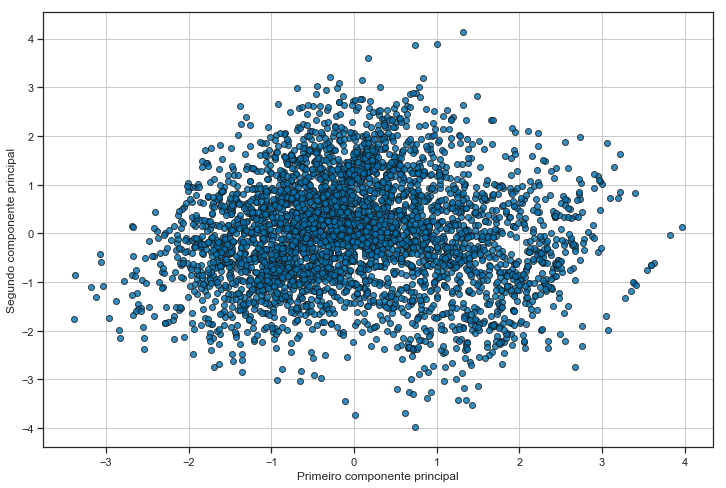

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

Por curiosidade, vamos ver como ficariam os clusters encontrados na aula de clustering representados por esses dois componentes.

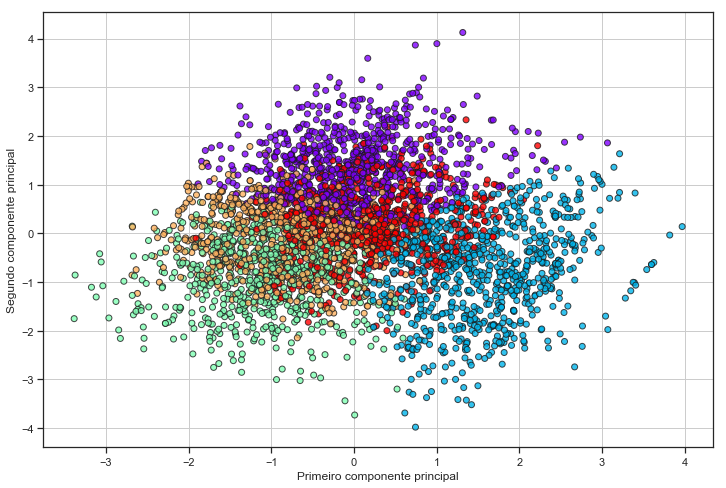

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

labels = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='rainbow', alpha=0.8, edgecolor='k')
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.grid()
plt.show()

Note que os eixos agora não representam as latitudes e longitudes de origem e destino. Na verdade, agora os eixos representam a combinação entre todas as outras features. Podemos ver que agora com apenas dois eixos, nós conseguimos representar o problema de maneira resumida. Os clusters parecem fazer mais sentido também. Há uma melhor separação visual. Mas, quão bem conseguimos representar o sistema com apenas dois eixos?

Para responder a essa pergunta, nós temos que utilizar o conceito de **variância explicada**. Como o algoritmo PCA procura encontrar eixos descorrelacionados e com ordem decrescente de variância, nós podemos obter qual é a variância contida em cada um dos eixos principais encontrados. Se acumularmos a variância de todos os eixos, nós teremos uma variância explicada de 100%, mas se utilizarmos apenas os *n* primeiros eixos (n < total), nós teremos uma variância explicada sempre menor do que 100%. Portanto, nós poderemos ter uma boa noção de qual o número ideal de eixos que vamos utilizar no nosso problema observando o ponto de corte pela variância explicada até aquele eixo. Vamos visualizar isso na prática:

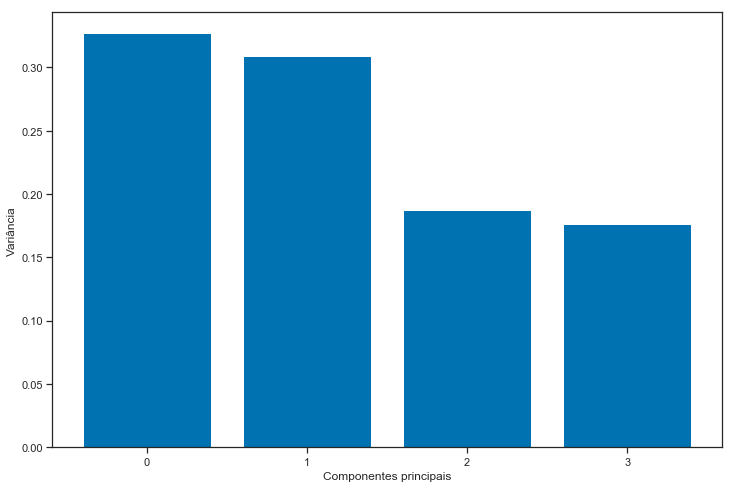

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 32.71%
2 Componente(s) principal(is): 63.59%
3 Componente(s) principal(is): 82.34%
4 Componente(s) principal(is): 100.00%


In [23]:
# Variância explicada das rotas
# Componentes principais
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_)
plt.xticks(features)
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

print('Variância explicada: ')
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print('-'*50)
for i in range(len(pca.explained_variance_ratio_)):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Podemos notar que com 2 eixos nós temos apenas 63% da variância explicada, o que é um valor relativamente baixo. Mas, como não estávamos tão interessados em grande precisão, podemos aceitar que os primeiros dois eixos já nos dão uma boa aproximação dos dados. Portanto, poderíamos ignorar os outros dois eixos, reduzindo assim a dimensionalidade do problema de 4 para 2. Reduzimos a dimensionalidade em 50%! Impressionante, não? Na verdade, não! Vamos ver o que a gente consegue fazer no problema de recomendação de produtos.

### Voltando ao exemplo de recomendação de produtos

Vamos agora tentar aplicar o método PCA no problema anterior e verificar se conseguimos melhorar o sistema de recomendação!

In [24]:
df_cat.head()

,title,short_description,url,title_desc
10578,noivinhos divertidos topo bolo rio,noivinhos topo bolo biscuit 10 cm altura faco ...,https://www.elo7.com.br/jfndgm/dp/B6A1D4,noivinhos divertidos topo bolo rio noivinhos t...
42,convite casamento,servir razao emocao tocar alma todos convites ...,https://www.elo7.com.br/jfndgm/dp/850FA3,convite casamento servir razao emocao tocar al...
61375,caixa 4 bombons flores 02,caixa 4 bombons otima opcao presentear chocola...,https://www.elo7.com.br/jfndgm/dp/6FCC99,caixa 4 bombons flores 02 caixa 4 bombons otim...
23432,kit amor 2,tal decorar casa quarto cantinho comemoracao d...,https://www.elo7.com.br/jfndgm/dp/A4A737,kit amor 2 tal decorar casa quarto cantinho co...
40033,topo bolo noivinhos,confeccionado biscuit personalize envie fotos ...,https://www.elo7.com.br/jfndgm/dp/5ADC46,topo bolo noivinhos confeccionado biscuit pers...


In [26]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_cat['title_desc'])

In [27]:
doc_target = 14
df_cat.iloc[doc_target]['title']

'copo long drink led festa formatura'

In [28]:
print("Dimensão: {}".format(X.shape[1]))

Dimensão: 5000


In [29]:
print('Esparsidade: {:.7%}'.format(1-len(X[X!=0])/np.prod(X.shape)))

Esparsidade: 99.9999980%


Agora vamos aplicar o PCA! Como o algoritmo implementado na função PCA do scikit-learn não suporta matrizes esparsas, nós precisamos utilizar a função [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). A única diferença desse algoritmo em relação ao PCA é o fato de ele não retirar a média dos dados antes de encontrar os componentes principais.

In [30]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=X.shape[1]-1)

In [31]:
X_svd = svd.fit_transform(X)

In [32]:
X_svd.shape

(10000, 4999)

Vamos agora encontrar a variância explicada pelos componentes principais.

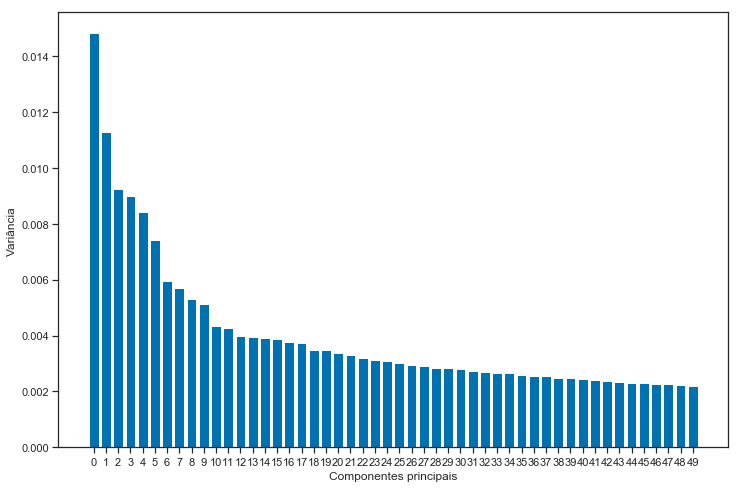

In [33]:
# Componentes principais
features = range(svd.components_.shape[1]-1)

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [34]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var)[:2000]

print('-'*50)
for i in range(0,len(exp_var[:2000]),100):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 1.48%
101 Componente(s) principal(is): 29.06%
201 Componente(s) principal(is): 40.81%
301 Componente(s) principal(is): 48.89%
401 Componente(s) principal(is): 55.13%
501 Componente(s) principal(is): 60.19%
601 Componente(s) principal(is): 64.42%
701 Componente(s) principal(is): 68.03%
801 Componente(s) principal(is): 71.15%
901 Componente(s) principal(is): 73.88%
1001 Componente(s) principal(is): 76.29%
1101 Componente(s) principal(is): 78.43%
1201 Componente(s) principal(is): 80.35%
1301 Componente(s) principal(is): 82.08%
1401 Componente(s) principal(is): 83.64%
1501 Componente(s) principal(is): 85.06%
1601 Componente(s) principal(is): 86.35%
1701 Componente(s) principal(is): 87.54%
1801 Componente(s) principal(is): 88.63%
1901 Componente(s) principal(is): 89.63%


Podemos verificar que conseguiríamos reduzir consideravelmente a dimensão do problema! Agora podemos utilizar tanto o método do cotovelo quanto um corte baseado na variância explicada do sistema. Vamos testar a utilização de um número bem reduzido de componentes principais e verificar como fica o resultado.

In [35]:
# teste outros valores de numero de componentes para verificar o resultado
# Note que quanto menor, maior é o valor das similaridades encontradas
svd = TruncatedSVD(n_components=500)

X_svd = svd.fit_transform(X)

X_svd.shape

(10000, 500)

Vamos repetir o método para encontrar as recomendações.

###### Cálculo da recomendação - PCA

In [36]:
## Solução
## Calcular a similaridade de cossenos desse artigo em relação a todos os outros e retornar os mais similares.
## Se o usuário gostou desse produto (consumiu), provavelmente gostará de outros semelhantes.

# Passo 1: Calcula, para cada par, a similaridade de cossenos
from sklearn.metrics.pairwise import cosine_similarity

# Matriz quadrada NxN (N = número de documentos) -> distância entre cada item (diagonal = 1)
similarity_matrix = cosine_similarity(X)
print('Tamanho matrix de similaridade: {}'.format(similarity_matrix.shape))

# Passo 2: Pegar a linha referente ao documento consumido e verificar quais produtos são mais semelhantes a ele
recommended_doc_indices = np.argsort(similarity_matrix[doc_target,:])[::-1]

# Passo 3: Escolher top 5 documentos para apresentar ao usuário
recommended_doc_indices = recommended_doc_indices[1:6] # elimina o próprio documento
print('Artigo consumido: doc {}'.format(doc_target))
print('Título: {}'.format(df_cat.iloc[doc_target]['title']))
print('---------------------------')

def find_common_words(tfidf, X, doc_target):
    doc_target_features = list(X[doc_target,:].todense().A[0])
    feature_names = tfidf.get_feature_names()
    words = [feature_names[i] for i in np.argsort(doc_target_features)[::-1][:5]]
    return words

print('\tPalavras comuns: {}\n'.format(find_common_words(tfidf, X, doc_target)))

print('Recomendação')
print('---------------------------')
for i, rec_idx in enumerate(recommended_doc_indices):
    print('- {}) Doc {}'.format(i,rec_idx))
    print('Título: {}'.format(df_cat.iloc[rec_idx]['title']))
    print('Similaridade: {:.3%}'.format(similarity_matrix[doc_target,rec_idx]))
    common_words = find_common_words(tfidf, X, rec_idx)
    print('Palavras comuns: {}'.format(common_words))
    print('-'*27+'\n')

Tamanho matrix de similaridade: (10000, 10000)
Artigo consumido: doc 14
Título: copo long drink led festa formatura
---------------------------
	Palavras comuns: ['led', 'drink', 'long', 'copo', 'descartaveis']

Recomendação
---------------------------
- 0) Doc 9776
Título: copo long drink led personalizado
Similaridade: 85.155%
Palavras comuns: ['led', 'drink', 'long', 'copo', 'descartaveis']
---------------------------

- 1) Doc 946
Título: copo long drink acrilico personalizados
Similaridade: 73.167%
Palavras comuns: ['drink', 'long', 'copo', 'descartaveis', 'acrilico']
---------------------------

- 2) Doc 4603
Título: copo long drink led personalizado
Similaridade: 65.833%
Palavras comuns: ['led', 'face', 'drink', 'long', 'copo']
---------------------------

- 3) Doc 7824
Título: copo long drink padrinhos
Similaridade: 53.999%
Palavras comuns: ['drink', 'long', 'copo', 'surpresa', 'padrinhos']
---------------------------

- 4) Doc 833
Título: copos personalizado long drink noivado

Compare os resultados com o métrodo padrão feito anteriormente: [Veja](#Cálculo-da-recomendação---Padrão)

Podemos ainda visualizar os dados com apenas os dois primeiros eixos principais:

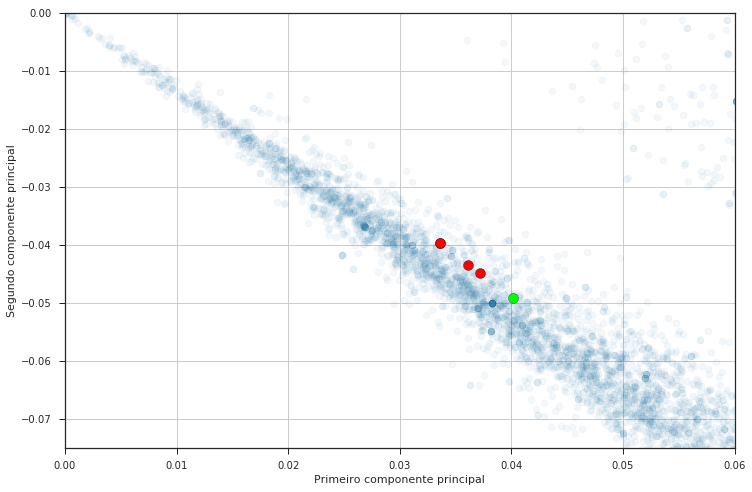

In [79]:
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.05, edgecolor='k')
plt.scatter(X_svd[recommended_doc_indices[0], 0], X_svd[recommended_doc_indices[0], 1], c=(0,1,0), edgecolor='k', s=100)
plt.scatter(X_svd[recommended_doc_indices[1:6], 0], X_svd[recommended_doc_indices[1:6], 1], c=(1,0,0), edgecolor='k', s=100)
plt.xlabel('Primeiro componente principal')
plt.ylabel('Segundo componente principal')
plt.xlim((0,0.06))
plt.ylim((-0.075,0))
plt.grid()
plt.show()

Podemos perceber os dados bem distribuídos, mas ainda não é possível notar uma estrutura próxima entre eles. Isso era esperado, já que os dois primeiros componentes principais só contém cerca de 2% da variância explicada. Para plotar esse gráfico, nós podemos utilizar outra ferramenta poderosa: o [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Mas, isso fica para uma outra oportunidade! =)

### Case Elo7: Motivos de compra

Agora tente aplicar o método PCA para encontrar relações entre os dados. Utilize as ferramentas apresentadas anteriormente para gerar um bom entendimento sobre o problema.

In [37]:
df_reason = pd.read_csv(os.path.join(DATASET_FOLDER, 'purchase_reason_elo7_dataset.csv'), sep=';')

df_reason.head(10)

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento
5,caixa 40 charuto de chocolate belga,lembranca de maternidade
6,arquivo de corte vamos brindar,mimo para mim
7,prateleira com varao mdf reta 96x20x14,decoracao do quarto da minha filha
8,colherzinha bailarina,aniversario
9,caixa cone arvore jardim dos passarinhos,festa


In [38]:
df_reason['reason'].values.size

100000

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_reason['reason'].values)

Aplique o método PCA.

In [40]:
# TODO
# Execute o PCA (TruncatedSVD)
# Encontre uma região de corte para reduzir a dimensionalidade
svd = _

# Aplique o método SVD
X_svd = _

# Vamos ver como ficou o novo tamanho
X_svd.shape

(100000, 495)

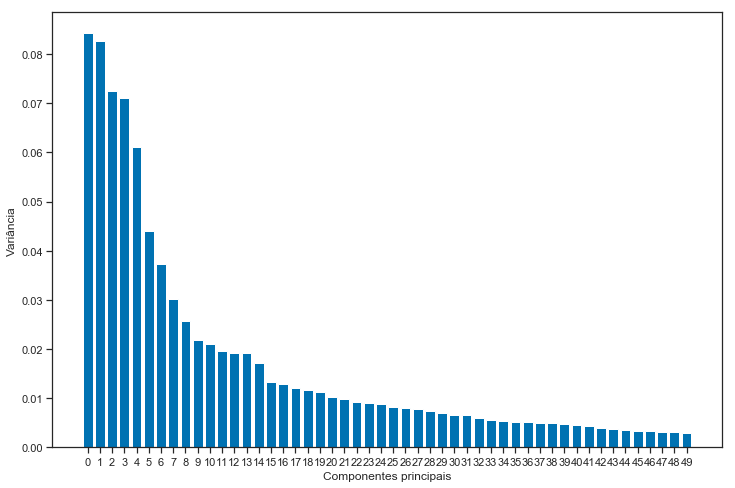

In [41]:
# Componentes principais
features = _

# Ordena os componentes - diferente do PCA que já vem ordenado
exp_var = np.sort(svd.explained_variance_ratio_)[::-1]

# Apresenta apenas os 50 primeiros
plt.bar(features[:50], exp_var[:50])
plt.xticks(features[:50])
plt.xlabel('Componentes principais')
plt.ylabel('Variância')
plt.show()

In [42]:
print('Variância explicada: ')
cum_exp_var = np.cumsum(exp_var[:100])

print('-'*50)
for i in range(0,len(exp_var[:100]),10):
    print('{} Componente(s) principal(is): {:.2%}'.format(i+1, cum_exp_var[i]))

Variância explicada: 
--------------------------------------------------
1 Componente(s) principal(is): 8.43%
11 Componente(s) principal(is): 55.14%
21 Componente(s) principal(is): 69.78%
31 Componente(s) principal(is): 78.00%
41 Componente(s) principal(is): 83.29%
51 Componente(s) principal(is): 86.70%
61 Componente(s) principal(is): 88.82%
71 Componente(s) principal(is): 90.32%
81 Componente(s) principal(is): 91.49%
91 Componente(s) principal(is): 92.49%


Podemos perceber que poderíamos facilmente utilizar apenas 70 dimensões. Isso já nos daria uma variância explicada de aproximadamente 90%.

In [81]:
svd = TruncatedSVD(n_components=70)

# Aplique o método SVD nos dados - Escolhe um subset por questão de memória
df_sample = df_reason.sample(n=10000)
X_sample = tfidf.transform(df_sample['reason'].values)

X_svd = svd.fit_transform(X_sample)

Legal! Conseguímos reduzir bastante as dimensões do nosso dataset, mas o que podemos fazer com isso agora? 
R: Qualquer coisa que poderíamos antes!

Podemos utilizar métodos de classificação, clustering ou até mesmo recomendações! A diferença é que agora temos um problema de menor dimensionalidade, mas completo.

Utilizando o exemplo dos motivos de compra do Elo7, nós poderíamos fazer um sistema de recomendação de produtos a partir da similaridade de movitos de compra. Não só recomendaríamos um produto a partir do que ele é (descrição), mas sim para que ele serve (motivo).

In [100]:
# Vamos tentar ver se conseguímos boas recomendações para esse produto:
target = _
print("Título do produto: {}".format(df_sample.iloc[target]['product_title']))
print("Motivo de compra: {}".format(df_sample.iloc[target]['reason']))

Título do produto: veu noiva longo 3 metros pronta entrega
Motivo de compra: para usar no meu casamento


Vamos encontrar outros produtos para recomendar para esse usuário:

In [101]:
# Passo 1: Calcula, para cada par, a similaridade de cossenos
from sklearn.metrics.pairwise import cosine_similarity

# Matriz quadrada NxN (N = número de documentos) -> distância entre cada item (diagonal = 1)
similarity_matrix = cosine_similarity(X_svd)

# Passo 2: Pegar a linha referente ao documento consumido e verificar quais produtos são mais semelhantes a ele
recommended_doc_indices = np.argsort(similarity_matrix[target,:])[::-1]

# Passo 3: Escolher top 5 documentos para apresentar ao usuário
recommended_doc_indices = recommended_doc_indices[1:6] # elimina o próprio documento
print('Produto alvo: \n\tTítulo: {}\n\tRazão: {}'.format(df_sample.iloc[target]['product_title'],
                                                         df_sample.iloc[target]['reason']))
print('---------------------------')

print('Recomendação')
print('---------------------------')
for i, rec_idx in enumerate(recommended_doc_indices):
    print('- {}) Produto {}'.format(i,rec_idx))
    print('Similaridade: {:.3%}'.format(similarity_matrix[target,rec_idx]))
    print('Produto alvo: \n\tTítulo: {}\n\tRazão: {}'.format(df_sample.iloc[rec_idx]['product_title'],
                                                             df_sample.iloc[rec_idx]['reason']))
    print('-'*27+'\n')

Produto alvo: 
	Título: veu noiva longo 3 metros pronta entrega
	Razão: para usar no meu casamento
---------------------------
Recomendação
---------------------------
- 0) Produto 567
Similaridade: 100.000%
Produto alvo: 
	Título: relicario para 4 fotos
	Razão: usar no meu casamento
---------------------------

- 1) Produto 5975
Similaridade: 100.000%
Produto alvo: 
	Título: frete gratis headband noiva taylor
	Razão: para usar no meu casamento
---------------------------

- 2) Produto 2952
Similaridade: 100.000%
Produto alvo: 
	Título: bomba do noivo dinamite do noivo
	Razão: usar no meu casamento
---------------------------

- 3) Produto 6923
Similaridade: 99.475%
Produto alvo: 
	Título: anel de noivado folheado a ouro branco
	Razão: pedido de casamento
---------------------------

- 4) Produto 49
Similaridade: 99.463%
Produto alvo: 
	Título: banner chalkboard casamento 2
	Razão: casamento
---------------------------



# Topic Analysis

Até agora, nós utilizamos diversos algoritmos de clustering e redução de dimensionalidade para conseguir encontrar relações de proximidade entre documentos. Entretanto, apesar de algoritmos como o PCA conseguirem representar reduzidamente o nosso conjunto de documentos, nós não conseguíamos interpretar o resultado obtido. Isso acontece porque o PCA encontra novos vetores de features que são combinações lineares do conjunto de palavras existentes. Esse fator pode não ser um problema se o que se deseja é apenas encontrar clusters sem interpretações mais profundas. Entretanto, muitas vezes gostaríamos de entender o racional por trás da geração dos clusters. Ainda mais, as vezes gostaríamos de reduzir um documento a um conjunto de palavras-chave que podem "resumir" o nosso documento e agrupá-las em **tópicos**. E é exatamente esse o objetivo dessa aula.

A área de topic analysis é de grande importância para Machine Learning, ou mais especificamente a área de Data Mining. A utilização de tópicos nos permite ter uma melhor e mais compacta representação dos nossos dados, principalmente quando temos um conjunto extenso de dados e atributos (features). 

Utilizar topic analysis em Natural Language Processing (NLP) é algo bem intuitivo. Nós naturalmente fazemos isso quando queremos organizar textos (documentos) em diferentes categorias, ou temas. Por exemplo, nós podemos ler artigos do Google News e dizer facilmente que um determinado artigo tem o tema "esporte", ou o tema "política". Nosso trabalho em topic analysis é o de conseguir desenvolver algoritmos de Machine Learning que possam encontrar automaticamente esses tópicos, ou temas, por nós.

## Non-Negative Matrix Factorization NMF

O [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) é um algoritmo poderoso (apesar de relativamente simples) para encontrar tópicos em um conjunto de documentos e features. Ele se baseia em um processo de decomposição de matrizes para criar uma representação adequada da matriz de frequência de palavras (denotado por __"A"__). Mais especificamente, o NMF decompõe a matriz de frequência de palavras em duas: a primeira é a matriz de pesos (chamada de **W**), com as linhas representando os documentos e as colunas indicando os tópicos; e a segunda é a matriz de atributos (chamada de __H__), com as linhas indicando os tópicos e as colunas os atributos. O número de tópicos é definido antecipadamente e é fixo.

<img src="./imagens/nmf_draw.png" alt="Drawing" style="width: 500px;"/>

As duas matrizes são formadas a partir de um processo iterativo de otimização (veja esse [link](http://www.columbia.edu/~jwp2128/Teaching/E4903/papers/nmf_nature.pdf) para mais detalhes) com o objetivo de reconstruir fielmente a matriz A. Entretanto, para esse fim, a matriz **A** não pode possuir entradas negativas.

Vamos aplicar esse método na prática para verificar o resultado!

---
# Case recomendação de produtos Elo7

In [53]:
df_cat.head()

,title,short_description,url,title_desc
10578,noivinhos divertidos topo bolo rio,noivinhos topo bolo biscuit 10 cm altura faco ...,https://www.elo7.com.br/jfndgm/dp/B6A1D4,noivinhos divertidos topo bolo rio noivinhos t...
42,convite casamento,servir razao emocao tocar alma todos convites ...,https://www.elo7.com.br/jfndgm/dp/850FA3,convite casamento servir razao emocao tocar al...
61375,caixa 4 bombons flores 02,caixa 4 bombons otima opcao presentear chocola...,https://www.elo7.com.br/jfndgm/dp/6FCC99,caixa 4 bombons flores 02 caixa 4 bombons otim...
23432,kit amor 2,tal decorar casa quarto cantinho comemoracao d...,https://www.elo7.com.br/jfndgm/dp/A4A737,kit amor 2 tal decorar casa quarto cantinho co...
40033,topo bolo noivinhos,confeccionado biscuit personalize envie fotos ...,https://www.elo7.com.br/jfndgm/dp/5ADC46,topo bolo noivinhos confeccionado biscuit pers...


In [54]:
tfidf = TfidfVectorizer(max_df=0.9, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_cat['title_desc'])

In [55]:
# Primeiro, importe o módulo NMF do scikit-learn
from sklearn.decomposition import NMF

# Precisamos criar a instância do NMF
# Vamos escolher 25 tópicos
n_topics = 25
nmf = NMF(n_components=n_topics)

# Agora vamos utilizar os mesmos atributos fit, transform ou fit_transform
# que já conhecemos do universo do sklearn
W_nmf = nmf.fit_transform(X)

# Vamos ver qual é a dimensão de W_nmf
W_nmf.shape

(10000, 25)

Note que o número de linhas se manteve em 10000, que é o número de documentos (produtos) que nós temos, e o número de colunas se transformou em 25, que é o número de tópicos que nós escolhemos. Essa matriz gerada representa a matriz **W** (matriz de pesos) da fatoração de matrizes.

Vamos agora achar a matriz **H** que representa a matriz de atributos.

In [56]:
H_nmf = nmf.components_
H_nmf.shape

(25, 5000)

Note que o número de linhas é igual ao número de tópicos e o número de colunas representa o número de palavras no nosso vocabulário. Cada linha da matriz é definida como um componente (assim como o PCA possui os componentes principais) que está associado a um tópico específico. Entretanto, diferentemente do PCA, nós podemos associar cada componente a um conjunto específico de palavras. Vamos verificar abaixo:

In [57]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = tfidf.get_feature_names()

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(H_nmf, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(n_topics):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest())
    print("----------")

Topico 0:
----------
razao     1.650054
tocar     1.650054
emocao    1.645837
alma      1.644042
servir    1.641460
Name: 0, dtype: float64
----------
Topico 1:
----------
convite      8.425530
papel        5.132549
casamento    3.454655
envelope     2.574327
180g         1.890365
Name: 1, dtype: float64
----------
Topico 2:
----------
bolo             2.059056
topo             2.002679
personalizado    0.235632
biscuit          0.178740
casamento        0.170992
Name: 2, dtype: float64
----------
Topico 3:
----------
porta          2.240326
guardanapo     2.156735
flor           0.577475
guardanapos    0.546811
perola         0.463288
Name: 3, dtype: float64
----------
Topico 4:
----------
diferenciados    0.881143
quantidades      0.880677
maiores          0.880663
precos           0.859811
chine            0.839450
Name: 4, dtype: float64
----------
Topico 5:
----------
caixa        2.072377
mdf          0.982399
padrinhos    0.687977
tecido       0.670679
tampa        0.608366
Name

In [58]:
# Nós vamos ter que normalizar o vetor de atributos
# Isso é necessário para que todas as features (tópicos) 
# de um documento some 1 ao final
# Seria a porcentagem de composição dos tópicos 
# no documento
from sklearn.preprocessing import normalize
W_nmf_norm = normalize(W_nmf)

In [64]:
# Vamos criar um dataframe:
# índice: documento
# colunas: vetor de features (normalizadas)
df = pd.DataFrame(W_nmf_norm,
                  columns=['topic {}'.format(i) for i in range(n_topics)],
                  index=['prod {}'.format(i) for i in range(len(df_cat))])
df.head(5)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20,topic 21,topic 22,topic 23,topic 24
prod 0,0.000000,0.000000,0.752853,0.0,0.097624,0.000000,0.000000,0.000000,0.553756,0.0,...,0.000000,0.000000,0.336480,0.000000,0.0,0.000000,0.024457,0.000000,0.000000,0.000000
prod 1,0.999974,0.004723,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000266,0.000000,0.0,0.000000,0.005026,0.000000,0.000000,0.000000
prod 2,0.000000,0.000000,0.000000,0.0,0.000000,0.743787,0.000000,0.095253,0.001662,0.0,...,0.039287,0.000000,0.000000,0.372393,0.0,0.000000,0.130697,0.027966,0.000000,0.528793
prod 3,0.000000,0.002221,0.010932,0.0,0.000000,0.000000,0.022718,0.000000,0.015002,0.0,...,0.000000,0.023516,0.000000,0.000000,0.0,0.017108,0.000000,0.947465,0.315649,0.000000
prod 4,0.000000,0.000000,0.632042,0.0,0.000000,0.000000,0.000000,0.000000,0.551142,0.0,...,0.055503,0.000000,0.000000,0.000000,0.0,0.521899,0.064817,0.000000,0.026703,0.045837


In [65]:
# Vamos pegar o mesmo artigo escolhido anteriormente
doc_target

14

In [66]:
# Verifica o vetor de features dele:
doc_target_features = df.iloc[doc_target]
print(doc_target_features)

topic 0     0.000000
topic 1     0.000000
topic 2     0.081396
topic 3     0.117531
topic 4     0.000000
topic 5     0.000000
topic 6     0.308755
topic 7     0.000000
topic 8     0.000000
topic 9     0.258633
topic 10    0.019789
topic 11    0.000000
topic 12    0.000000
topic 13    0.000000
topic 14    0.099479
topic 15    0.000000
topic 16    0.000000
topic 17    0.000000
topic 18    0.384811
topic 19    0.000000
topic 20    0.241424
topic 21    0.662240
topic 22    0.238806
topic 23    0.112854
topic 24    0.303909
Name: prod 14, dtype: float64


In [67]:
# Calcula a similaridade de cossenos entre o produto e 
# todos os outros documentos
cossine_similarity = df.dot(doc_target_features)

# Todos os documentos com maior similaridade de cossenos 
# representam os documentos mais próximos
print("Artigos recomendados:")
recommendations = cossine_similarity.nlargest(6)[1:]
print(recommendations)

Artigos recomendados:
prod 5467    0.905995
prod 8766    0.905995
prod 219     0.895369
prod 1687    0.863769
prod 93      0.854129
dtype: float64


In [68]:
df.head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,...,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20,topic 21,topic 22,topic 23,topic 24
prod 0,0.000000,0.000000,0.752853,0.0,0.097624,0.000000,0.000000,0.000000,0.553756,0.0,...,0.000000,0.000000,0.336480,0.000000,0.0,0.000000,0.024457,0.000000,0.000000,0.000000
prod 1,0.999974,0.004723,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000266,0.000000,0.0,0.000000,0.005026,0.000000,0.000000,0.000000
prod 2,0.000000,0.000000,0.000000,0.0,0.000000,0.743787,0.000000,0.095253,0.001662,0.0,...,0.039287,0.000000,0.000000,0.372393,0.0,0.000000,0.130697,0.027966,0.000000,0.528793
prod 3,0.000000,0.002221,0.010932,0.0,0.000000,0.000000,0.022718,0.000000,0.015002,0.0,...,0.000000,0.023516,0.000000,0.000000,0.0,0.017108,0.000000,0.947465,0.315649,0.000000
prod 4,0.000000,0.000000,0.632042,0.0,0.000000,0.000000,0.000000,0.000000,0.551142,0.0,...,0.055503,0.000000,0.000000,0.000000,0.0,0.521899,0.064817,0.000000,0.026703,0.045837


###### Cálculo da recomendação - NMF

In [69]:
default_top_topics = df.iloc[doc_target].nlargest(3).index.values
default_components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values 
                      for i in default_top_topics]

print("Artigo original: doc {}".format(doc_target))
print("Título: {}".format(df_cat.iloc[doc_target]['title']))
print("-----------------------")
print("- Tópicos (palavras): ")
for i in range(len(default_top_topics)):
    print("{:>15} ({})".format(default_top_topics[i], ', '.join(default_components[i])))
print("\n\n")

for doc, similarity in recommendations.items():
    doc_num = int(doc.split(' ')[1])
    top_topics = df.iloc[doc_num].nlargest(3).index.values
    components = [components_df.iloc[int(i.split(' ')[1])].nlargest(5).index.values for i in top_topics]
    print("Recomendação {}:".format(doc))
    print("Título: {}".format(df_cat.iloc[doc_num]['title']))
    print("-----------------------")
    print("- Similaridade: {:.2%}".format(similarity))
    print("- Tópicos (palavras): ")
    for i in range(len(top_topics)):
        print("{:>15} ({})".format(top_topics[i], ', '.join(components[i])))
    print("\n")

Artigo original: doc 14
Título: copo long drink led festa formatura
-----------------------
- Tópicos (palavras): 
       topic 21 (personalizado, chinelo, chinelos, casamento, personalizados)
       topic 18 (antes, compra, duvidas, produto, prazo)
        topic 6 (digital, arte, monograma, convite, casamento)



Recomendação prod 5467:
Título: copo long drink 320ml casamento
-----------------------
- Similaridade: 90.60%
- Tópicos (palavras): 
       topic 21 (personalizado, chinelo, chinelos, casamento, personalizados)
       topic 18 (antes, compra, duvidas, produto, prazo)
        topic 6 (digital, arte, monograma, convite, casamento)


Recomendação prod 8766:
Título: copo long drink 320ml casamento
-----------------------
- Similaridade: 90.60%
- Tópicos (palavras): 
       topic 21 (personalizado, chinelo, chinelos, casamento, personalizados)
       topic 18 (antes, compra, duvidas, produto, prazo)
        topic 6 (digital, arte, monograma, convite, casamento)


Recomendação pro

Compare os resultados:
- [Padrão](#Cálculo-da-recomendação---Padrão)
- [PCA](#Cálculo-da-recomendação---PCA)

### Case Elo7: Motivos de Compra

Agora aplique o NMF no dataset de motivos de compra e verifique o resultado comparado ao PCA.

In [177]:
df_reason.head()

,product_title,reason
0,apliques recortados fundo do mar,festa de 2 anos do meu filho
1,mini raposa vermelha amigurumi,presente para mim
2,o pequeno principe i bata,aniversario
3,quadro maternidade menino elefante,nascimento do meu bebe
4,livro de votos casamento o par,casamento


In [178]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=5000, sublinear_tf=True, use_idf=True)

X = tfidf.fit_transform(df_reason['reason'].values)

In [179]:
from sklearn.decomposition import NMF

n_components = _
nmf = _

# Aplique o método SVD
W_nmf = _

# Vamos ver como ficou o novo tamanho
W_nmf.shape

(100000, 20)

In [180]:
# Precisamos criar uma lista de palavras que representam as 
# colunas da matriz de frequência de palavras
words = [x[0] for x in sorted(tfidf.vocabulary_.items())]

# Vamos criar um dataframe para visualizar
components_df = pd.DataFrame(nmf.components_, columns=words)

# Vamos verificar as palavras que representam cada um dos tópicos
for i in range(W_nmf.shape[1]):
    component = components_df.iloc[i]
    print("Topico {}:".format(i))
    print("----------")
    print(component.nlargest(10))
    print("----------")

Topico 0:
----------
aniversario      12.530379
da                0.140119
ano               0.070469
infantil          0.060511
filhos            0.051726
dos               0.036774
meus              0.030062
lembranca         0.028891
lembrancinhas     0.027761
sobrinha          0.027351
Name: 0, dtype: float64
----------
Topico 1:
----------
presente     10.671258
amiga         0.117962
um            0.117090
natal         0.103643
principe      0.094999
sobrinha      0.084605
padrinhos     0.061403
uma           0.056301
filha         0.056258
pra           0.054643
Name: 1, dtype: float64
----------
Topico 2:
----------
casamento        9.663092
convite          0.192689
padrinhos        0.079059
convites         0.061377
lembrancas       0.020893
meu              0.016339
madrinhas        0.015956
nosso            0.013103
lembranca        0.011499
lembrancinhas    0.005855
Name: 2, dtype: float64
----------
Topico 3:
----------
filha         6.999026
minha         5.414866
da   

Podemos ainda utilizar os tópicos mais relevantes dos produtos dentro de clusters. Como vimos na aula 27 - Clustering, vamos tentar verificar como seria a relação hierárquica entre os tópicos dos produtos.

In [181]:
# Cria as labels a partir do tópico mais relevante de cada artigo
labels = np.argmax(W_nmf, axis=1)

# Cria o novo dataframe com os labels dos clusters
df = pd.DataFrame({'label': labels, 'reason': df_reason['reason']})

# Pega um sample
df_sample = df.sample(n=60)

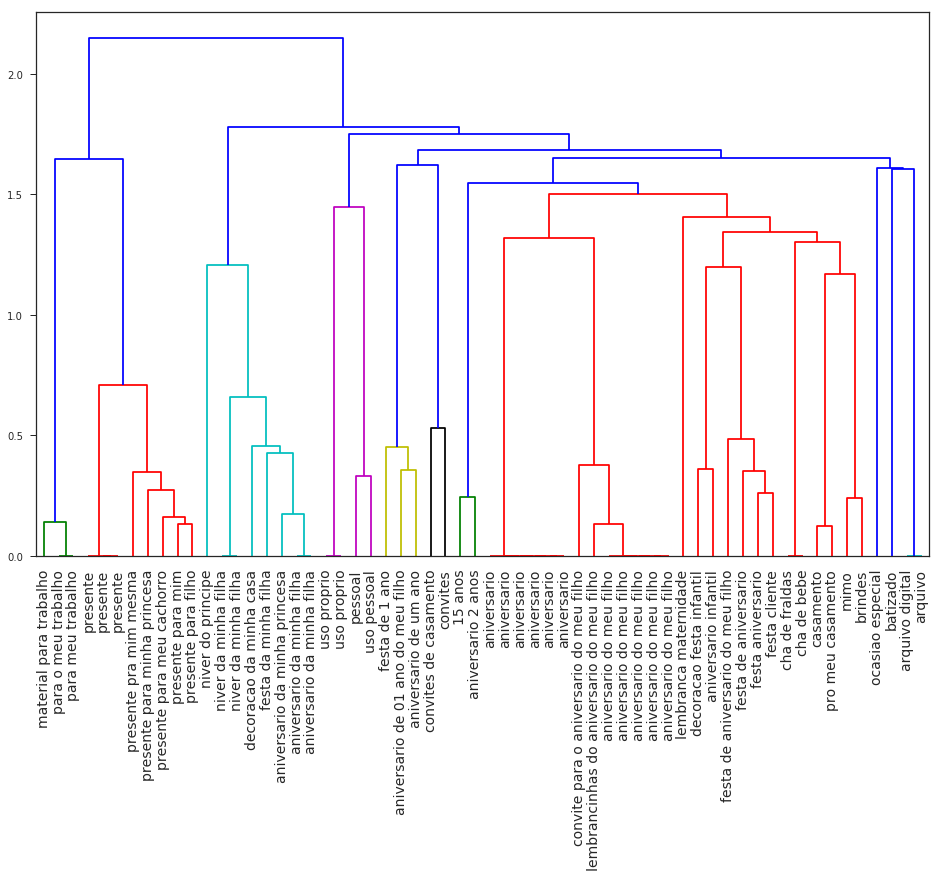

In [182]:
from scipy.cluster.hierarchy import linkage, dendrogram

X_sample = df_sample['reason'].values

W_nmf = nmf.fit_transform(tfidf.fit_transform(X_sample))

Y = linkage(W_nmf, method='ward', metric='euclidean')

dendrogram(Y,
           labels=df_sample['reason'].values,
           leaf_rotation=90,
           leaf_font_size=14,
)
plt.show()

---
# Recomendação com Filtro Colaborativo

## Case: Recomendação Filmes

Este case foi tema de um dos processos seletivos que utilizamos para uma vaga de Data Scientist no Elo7! A descrição exata deste teste pode ser encontrada nesse [notebook](teste_data_science.ipynb).

Este dataset é muito utilizado na área de recomendação para testar algoritmos de recomendação. O objetivo dele é tentar prever a avaliação (de 1 a 5) que um usuário daria para um filme que ele ainda não viu baseado em outros filmes que ele avaliou. Esse dataset foi retirado do [MovieLens](https://grouplens.org/datasets/movielens/) e contém 100004 avaliações de 671 usuários a 9125 filmes.



In [208]:
df_movies = pd.read_csv(os.path.join(DATASET_FOLDER,'movie_lens_dataset.csv'))

df_movies.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [209]:
df_movies_pivot = df_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0)
df_movies_pivot.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [210]:
X = df_movies_pivot.values

In [211]:
print('Esparsidade: {:.2%}'.format(len(X[X==0])/np.prod(X.shape)))

Esparsidade: 98.36%


Existem muitos campos vazios, ou seja, sem avaliação. Na área de sistemas de recomendação, isso não representa que esses usuários não se interessaram por esses filmes, mas sim que eles não tiveram a oportunidade de avaliá-los. Dessa forma, o que gostaríamos é de predizer qual seria a avaliação de um usuário de um filme não visto por ele. Filmes que possuírem as melhores avaliações preditas serão recomendados para o usuário. Parece bem simples, não?

A técnica de filtro colaborativo é muito utilizada para recomendação de filmes. A ideia do filtro colaborativo é utilizar a "inteligência da população" para ajudar a prever o comportamento de um indivíduo. Por exemplo, seria intuitivo pensar que se dois usuários assistem e avaliam filmes semelhantemente, nós podemos utilizar a avaliação de um dos usuários para prever avaliação do outro. Essa ideia está representada na figura abaixo.

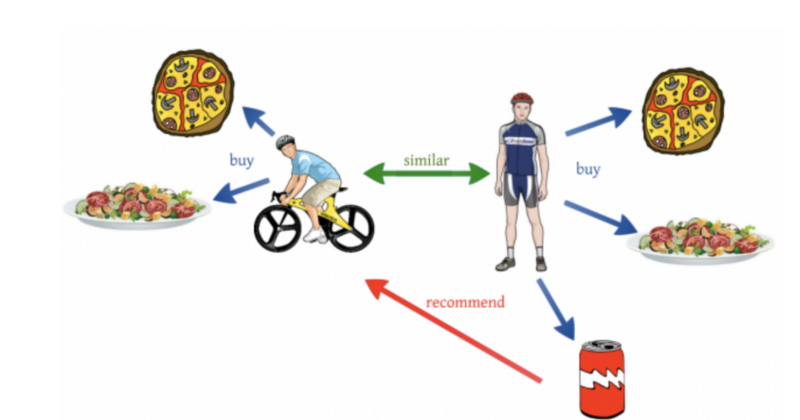

O método de Filtro Colaborativo possui duas vertentes principais. A primeira é baseada em **memória** e a segunda é baseada em **modelo**. Abaixo apresento as duas formas.

### Filtro colaborativo baseado em memória

Esse método é dito que é baseado em memória porque não procura modelar o interesse do usuário de alguma forma (método não paramétrico). O que ele faz é tentar predizer a avaliação de um usuário para um determinado item ao ponderar as votações de usuários semelhantes a ele. Quanto mais próximos são os usuários, maior é a valor dado para a votação desse usuário na ponderação.

O filtro colaborativo baseado em memória é ainda dividido em duas áreas principais:

- Filtro Colaborativo Item-Item: **“Usuários que gostaram disso também gostaram ...”**

    Esse método utiliza a proximidade entre itens para recomendar outros itens para um usuário. Itens são considerados semelhantes se forem avaliados de forma semelhante pelos usuários.


- Filtro Colaborativo Usuário-Item: **“Usuários semelhantes a você gostaram ...”**
    
    Diferentemente do método anterior, esse método utiliza a proximidade entre usuários para recomendar outros itens para um usuário. Usuários são considerados semelhantes se eles avaliam semelhantemente os itens consumidos. Por exemplo, se o usuário A e B avaliam os filmes X e Y de maneira semelhante, mas só o usuário B avaliou de forma positiva o filme Z, seria intuitivo recomendar o filme Z para o usuário A.

Vamos testar os dois métodos!

Vamos primeiro criar um dataset de treino e teste.

In [212]:
# Gera um conjunto aleatório das avaliações
df_movies = df_movies.sample(frac=1)

# Escolhe um corte para escolher os dados de treino e teste
train_ratio = 0.75
threshold = int(train_ratio * len(df_movies))

train_movies = df_movies[:threshold]
test_movies = df_movies[threshold:]

In [213]:
# Vamos criar as matrizes de treino e teste
X_train = train_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0).values
X_test = test_movies.pivot_table(values='rating',index='userId',columns='movieId').fillna(0).values

Vamos agora calcular as similaridades entre itens e usuários.

In [214]:
from sklearn.metrics.pairwise import pairwise_distances

user_similarity_matrix = pairwise_distances(X_train, metric='cosine')
item_similarity_matrix = pairwise_distances(X_train.T, metric='cosine')

Vamos criar uma função que prediz a avaliação do usuário baseado em similaridades de itens e de usuários.

In [215]:
def predict(X, similarity_matrix, type='user'):
    if type == 'user':
        X_mean = np.mean(X, axis=1)[:, np.newaxis]
        # retiramos a média dos dados
        X_diff = (X - X_mean)
        # Adiciona a média de avaliação dos usuários
        # Usuários possuem um viés de votação, 
        # portanto consideramos esse viés na nossa predição
        pred = X_mean + similarity_matrix.dot(X_diff) / np.array([np.abs(similarity_matrix).sum(axis=1)]).T
    elif type == 'item':
        pred = X.dot(similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])
    return pred

Gera as predições.

In [216]:
item_prediction = predict(X_train, item_similarity_matrix, type='item')
user_prediction = predict(X_train, user_similarity_matrix, type='user')

Para avaliar a predição, nós vamos utilizar o "root mean squared error" (rmse). Essa métrica é comumente utilizada para avaliar a magnitude dos erros de predição de regressores. Quanto menor o valor do `rmse`, melhor a precisão do nosso recomendador.

In [217]:
from sklearn.metrics import mean_squared_error

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [218]:
print('Filtro colaborativo User-Item RMSE: {:.4f}'.format(rmse(user_prediction, X_test)))
print('Filtro colaborativo Item-Item RMSE: {:.4f}'.format(rmse(item_prediction, X_test)))

Filtro colaborativo User-Item RMSE: 3.5294
Filtro colaborativo Item-Item RMSE: 3.5656


Os dois algoritmos parecem ter precisão semelhante, com uma leve vantagem do algoritmo User-Item.

---
### Filtro colaborativo baseado em modelo

O método apresentado aqui difere do modelo anterior ao tentar criar um modelo do usuário (método paramétrico). Existem diversos algoritmos que entram na definição de filtro colaborativo baseado em modelo, mas os mais comuns são baseados em [fatorização de matrizes](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

O objetivo principal da fatorização de matrizes é o de encontrar as características intrínsecas dos usuários e itens. Essas características podem explicar as motivações que levaram um usuário a avaliar esses itens.

A técnica mais famosa para fatorar matrizes em sistemas de recomendação é o [SVD](https://en.wikipedia.org/wiki/Singular-value_decomposition), principalmente depois que foi utilizada na [competição de recomendações do Netflix](https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429). A ideia principal do SVD pode ser vista na figura abaixo:

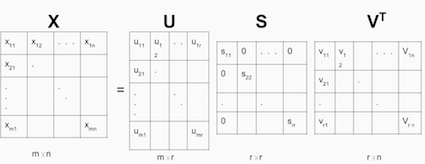

Nós temos a matriz X, que representa a matriz de usuários e itens avaliados. Nós podemos fatorar essa matriz para encontrar as matrizes U, S e V, onde a matriz U contém os componentes latentes dos usuários, a matriz S é uma matriz diagonal que contém os valores singulares de X e V contém os componentes latentes dos itens. Como a matriz X é uma matriz com alto grau de esparsidade (>90%), a fatoração não pode ser feita da maneira tradicional de álgebra. Contudo, existem aproximações que funcionam bem na prática, como a utilização do método do gradiente descendente ou do algoritmo ARPACK utilizado pelo `scipy`. A partir do momento que conseguimos encontrar as matrizes U, S e V, nós conseguimos calcular a nova matriz X', que é a predição dos valores de avaliação dos itens não avaliados anteriormente.

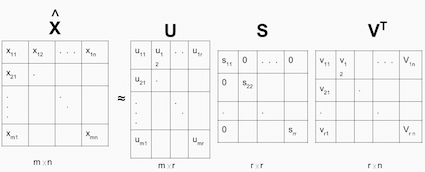

Vamos agora tentar utilizar esses conceitos para encontrar as recomendações dos filmes!

In [221]:
from scipy.sparse.linalg import svds

# Vamos fatorar a matriz de treino para encontrar as matrizes U,S e V
# Nós precisamos definir o número de variáveis latentes do sistema
# Teste valores diferentes de k para verificar a qualidade do resultado
u, s, vt = svds(X_train, k = 20)
s_diag_matrix = np.diag(s)

# Prediz as avaliações
X_pred = u.dot(s_diag_matrix).dot(vt)

# Verifica o resultado utilizando o RMSE
print('Filtro colaborativo SVD RMSE: {:.4f}'.format(rmse(X_pred, X_test)))

Filtro colaborativo SVD RMSE: 3.5148


Podemos notar que o filtro colaborativo utilizando o SVD possui uma precisão maior do que os métodos baseados em memória.

Que melhorias você faria no algoritmo para atingir um resultado ainda melhor? Leia [esse](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf) artigo que explica a utilização de fatorização de matrizes na competição da Netflix para mais ideias.